In [1]:
import pandas as pd
import tensorflow as tf
from transformers import RobertaTokenizer, TFRobertaModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
data = pd.read_csv("/Users/withmocha/Desktop/DATA/BOAZ/미니 프로젝트 1/data/main data/WELFake_Dataset.csv")
data.drop(data.columns[0], axis=1, inplace=True)
data['title'] = data['title'] + data['text']
data

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
...,...,...,...
72129,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0
72130,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1
72131,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0
72132,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0


In [3]:
X = pd.DataFrame(data=data['title'])
Y = pd.DataFrame(data=data['label'])

In [4]:
texts = X['title'].tolist()
labels = Y['label'].tolist()
texts = [str(text) if pd.notna(text) else "" for text in texts]

In [5]:
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, shuffle=True)

In [6]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

In [7]:
def encode_data(texts, tokenizer, max_length=128):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            max_length=max_length,
            truncation=True,
            padding='max_length',
            add_special_tokens=True,
            return_attention_mask=True,
            return_tensors='tf'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    return tf.concat(input_ids, axis=0), tf.concat(attention_masks, axis=0)

In [8]:
train_input_ids, train_attention_masks = encode_data(train_texts, tokenizer)
val_input_ids, val_attention_masks = encode_data(val_texts, tokenizer)

In [9]:
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'roberta.embeddings.position_ids', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [10]:
def create_transformer_input(input_ids, attention_masks, batch_size=32):
    def gen():
        for i in range(0, len(input_ids), batch_size):
            yield input_ids[i:i + batch_size], attention_masks[i:i + batch_size]

    dataset = tf.data.Dataset.from_generator(
        gen,
        output_signature=(tf.TensorSpec(shape=(None, input_ids.shape[1]), dtype=tf.int32),
                          tf.TensorSpec(shape=(None, attention_masks.shape[1]), dtype=tf.int32))
    )

    features = []
    for batch_input_ids, batch_attention_masks in dataset:
        outputs = roberta_model(batch_input_ids, attention_mask=batch_attention_masks)
        features.append(outputs.last_hidden_state[:, 0, :])

    return tf.concat(features, axis=0)

In [11]:
train_features = create_transformer_input(train_input_ids, train_attention_masks)
val_features = create_transformer_input(val_input_ids, val_attention_masks)

2024-08-22 22:10:46.812701: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-22 22:24:27.658015: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [29]:
input_layer = tf.keras.layers.Input(shape=(train_features.shape[1],), dtype=tf.float32)
dense_layer = tf.keras.layers.Dense(256, activation='elu')(input_layer)
dropout_layer = tf.keras.layers.Dropout(0.5)(dense_layer)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(dropout_layer)

model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 768)]             0         
                                                                 
 dense_4 (Dense)             (None, 256)               196864    
                                                                 
 dropout_39 (Dropout)        (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 197121 (770.00 KB)
Trainable params: 197121 (770.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [30]:
import numpy as np

train_labels = np.array(train_labels)
val_labels = np.array(val_labels)


EPOCHS = 100
BATCH_SIZE = 32

history = model.fit(
    train_features,
    train_labels,
    validation_data=(val_features, val_labels),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)


Epoch 1/100
1804/1804 [==============================] - 2s 1ms/step - loss: 0.5458 - accuracy: 0.7391 - val_loss: 0.3794 - val_accuracy: 0.8971
Epoch 2/100
1804/1804 [==============================] - 2s 1ms/step - loss: 0.3081 - accuracy: 0.9060 - val_loss: 0.2357 - val_accuracy: 0.9382
Epoch 3/100
1804/1804 [==============================] - 2s 1ms/step - loss: 0.2007 - accuracy: 0.9413 - val_loss: 0.1678 - val_accuracy: 0.9521
Epoch 4/100
1804/1804 [==============================] - 2s 1ms/step - loss: 0.1488 - accuracy: 0.9557 - val_loss: 0.1312 - val_accuracy: 0.9601
Epoch 5/100
1804/1804 [==============================] - 2s 1ms/step - loss: 0.1200 - accuracy: 0.9626 - val_loss: 0.1107 - val_accuracy: 0.9633
Epoch 6/100
1804/1804 [==============================] - 2s 1ms/step - loss: 0.1028 - accuracy: 0.9671 - val_loss: 0.0960 - val_accuracy: 0.9687
Epoch 7/100
1804/1804 [==============================] - 2s 1ms/step - loss: 0.0913 - accuracy: 0.9705 - val_loss: 0.0864 - val_ac

451/451 [==============================] - 0s 340us/step


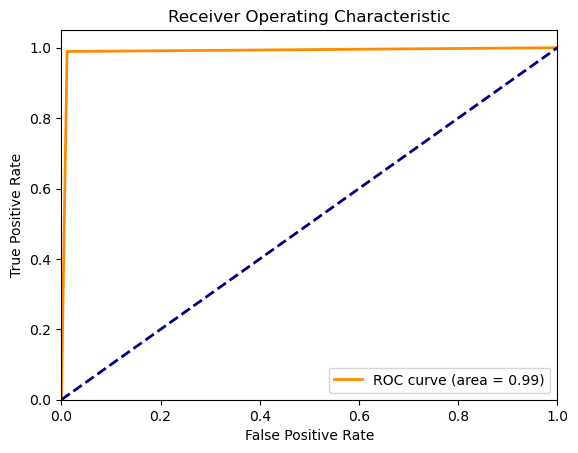

In [31]:
val_pred = model.predict(val_features)
val_pred = (val_pred > 0.5).astype(int)

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, accuracy_score

fpr, tpr, _ = roc_curve(val_labels, val_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

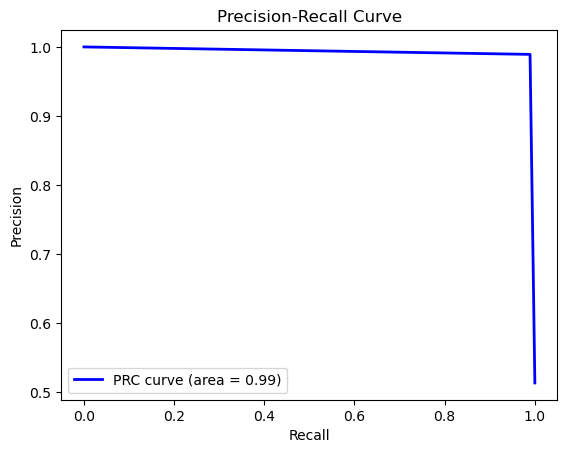

In [32]:
precision, recall, _ = precision_recall_curve(val_labels, val_pred)
prc_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='PRC curve (area = %0.2f)' % prc_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

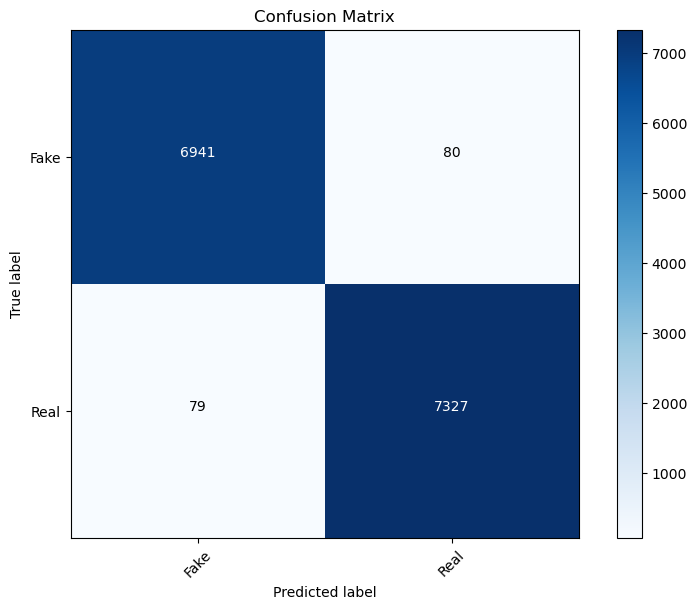

In [33]:
import itertools

conf_matrix = confusion_matrix(val_labels, val_pred)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Fake', 'Real'], rotation=45)
plt.yticks(tick_marks, ['Fake', 'Real'])

thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [36]:
accuracy = accuracy_score(val_labels, val_pred)
print('Accuracy Score:', accuracy)

Accuracy Score: 0.9889789977126222


In [35]:
model.save("transformer model.keras")